In [122]:
import re
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
import joblib
from step import *
import plotly
from sklearn import ensemble
from pycaret.regression import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [2]:
df_alg = pd.read_csv("../../data/joao-pessoa-aluguel.csv")
df1 = pd.read_csv("../../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)

In [3]:
df3 = pd \
    .read_csv('../../data/aluguel_social_jp.csv', delimiter=';') \
    .query('`ANO DO PAGAMENTO` == 2023') \
    .dropna(subset=['BAIRRO']) \
    .rename(columns={'BAIRRO': 'bairro'}) \
    .assign(bairro=lambda x: x.bairro.str.strip().str.title()) \
    .replace(
        {
            r'M[AaNnGg]([a-zA-Z])*\sI': 'Mangabeira I',
            r'M[AaNnGg]([a-zA-Z])*\sII': 'Mangabeira II',
            r'M[AaNnGg]([a-zA-Z])*\sIII': 'Mangabeira III',
            r'M[AaNnGg]([a-zA-Z])*\sIV': 'Mangabeira IV',
            r'M[AaNnGg]([a-zA-Z])*\sVii': 'Mangabeira IV',
            'Mangabeira Iv': 'Mangabeira IV',
            'Mangabeira Iii': 'Mangabeira III',
            'Mangabeira Ii': 'Mangabeira II',
            'Mangabeira Vi': 'Mangabeira VI',
            'Mangabeira Vii': 'Mangabeira VII',
            'Mangabeira Viii': 'Mangabeira VIII',
            'Mangabeira, Viii': 'Mangabeira VIII',
            'Mangabeira 8': 'Mangabeira VIII',
            r'M[AaNnGg]([a-zA-Z])*': 'Mangabeira',
            r'Varad([a-zA-Z]).*': 'Varadouro',
            'Jd Veneza': 'Jardim Veneza',
            'Jd Cidade Universitaria': 'Jardim Cidade Universitaria',
            'Mangabeira \( Aratu\)': 'Mangabeira',
            'Monsenhor Mangabeira': 'Mangabeira',
            'Mangabeira 1': 'Mangabeira',
            'Mangabeira \(Aratu\)': 'Mangabeira',
            'Bairro Dos Estados': 'Estados',
            'Mangabeira 6': 'Mangabeira VI',
            'Cristo': 'Cristo Redentor',
        },
        regex=True
    ) \
    .replace(
        {
            'Monsenhor Mangabeira': 'Mangabeira',
            'Baixo Roger': 'Roger',
            'Funcionarios 2': 'Funcionarios II a IV',
            'Cristo Redentor Redentor': 'Cristo Redentor',
            'Baixo Roger ( Vila Lula\nLucena)': 'Roger',
            'Collinas Do Sul': 'Colinas do Sul',
            'Cidade Verde - Bairro Das Industrias': 'Bairro das Industrias',
            'Cristo Redentor/Vale Das Palmeiras': 'Cristo Redentor',
            'Biarro Das Industria': 'Bairro das Industrias',
            'Altiplano 2': 'Altiplano',
            'Dos Ipes': 'Bairro Dos Ipes',
            'Aeroclube/Bessa': 'Aeroclube',
            'Bairro Sao Jose': 'Sao Jose',
            'B. Industrias': 'Bairro das Industrias',
            'Industrias': 'Bairro das Industrias',
            'B Das Industrias': 'Bairro das Industrias',
            'Funcionarios Ii': 'Funcionarios II a IV',
            'Bela Vista/Cristo Redentor': 'Cristo Redentor',
            'Sao Jose/ Barreira': 'Sao Jose',
            'B. Dos Estados': 'Estados',
            '13 De Mangabeira': 'Mangabeira',
            'Cristro Redentor': 'Cristo Redentor',
            'Funcionario Iii': 'Funcionarios II a IV',
            'Gervasio Mangabeira': 'Mangabeira',
            'Ipes': 'Bairro Dos Ipes',
            'B. Das Industrias': 'Bairro das Industrias',
            'Joao Paulo Ii': 'Joao Paulo II',
            'Padreze': 'Padre Ze',
            'Valentina I': 'Valentina',
            'B. Dos Novais': 'Bairro dos novais',
            'Novais': 'Bairro dos novais',
            'Treze De Mangabeira': 'Mangabeira',
            'Estados': 'Bairro dos estados'
        }
    ) \
    .reset_index(drop=True)
df3 = df3.replace({'Estados': 'bairro dos estados'})

df3 = df3.assign(bairro=lambda x: x.bairro.str.lower().str.replace(' ', '_')) \
    .groupby(['bairro'], as_index=False).size() \
    .rename(columns={'size': 'qnt_beneficio'})

In [4]:
def extract_location(address):
    pattern_joao_pessoa = re.compile(r'(.+),\s*João Pessoa$')
    match_joao_pessoa = pattern_joao_pessoa.search(address)

    if match_joao_pessoa:
        return match_joao_pessoa.group(1).strip()

    pattern_general = re.compile(r',\s*([^,]+)$')
    match_general = pattern_general.search(address)

    if match_general:
        return match_general.group(1).strip()

    return None

def clear_addr(x):
    pattern = re.compile(r'[-,\s]*(.*?)\s*,?\s*João Pessoa - PB')
    extracted_parts = [pattern.search(address).group(1) if pattern.search(address) else None for address in x]

    return [re.sub(r'^.* - ', '', address) for address in extracted_parts]

df1 = df1 \
    .assign(
        bairro=lambda x: clear_addr(x.endereco),
        error=lambda x: list(map(lambda y: ('Rua' in y) or (y == ''), x.bairro.tolist())),
    ) \
    .query('error == False') \
    .reset_index(drop=True) \
    .drop(columns=['error']) \
    .replace(
        {
            'Valentina Figueiredo': 'Valentina de Figueiredo',
            'Jardim Treze de Maio': 'Jardim 13 de Maio'
        }
    )

df2 = df2.assign(bairro=lambda x: [extract_location(address) for address in x.endereco])

df_alg = df_alg \
    .assign(bairro=lambda x: clear_addr(x.endereco)) \
    .replace({
        'Altiplano Cabo Branco': 'Altiplano',
        'ipes': 'Bairro dos Ipes',
        'Estados': 'Bairro dos estados',
        'Jardim Treze de Maio': 'Jardim 13 de Maio',
        'Ipês': 'Bairro dos Ipes'
    })

df_alg = df_alg \
    .assign(
        bairro=lambda x: x.bairro.str.normalize('NFKD') \
            .str.encode('ascii', errors='ignore') \
            .str.decode('utf-8') \
            .str.lower() \
            .str.replace(' ', '_')
    ) \
    .rename(
        columns={
            'area': 'area_aluguel',
            'valor': 'valor_aluguel',
            # 'vaga': 'vaga_aluguel',
            # 'quarto': 'quarto_aluguel',
            # 'banheiro': 'banheiro_aluguel'
            }
        ) \
    .groupby(['bairro'], as_index=False) \
    [['area_aluguel', 'valor_aluguel']] \
    .median()

In [5]:
df = pd.concat([df1, df2]) \
    .drop_duplicates('id') \
    .reset_index(drop=True) \
    .drop(columns=['id', 'url']) \
    .query('bairro != "Monsenhor Magno"') \
    .replace(
        {
            'Altiplano Cabo Branco': 'Altiplano',
            'Estados': 'Bairro dos estados',
            'Ipês': 'Bairro dos ipes',
            'Industrias': 'Bairro das Industrias',
            'Cidade dos Funcionarios II': 'Funcionários II a IV',
            'Cidade dos Colibris': 'Colibris',
            'Conjunto Pedro Gondim': 'Pedro gondim',
            'José Américo de Almeida': 'jose americo'
        }
    )

df = df \
    .assign(bairro=lambda x: x.bairro.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ', '_').str.lower()) \
    .merge(df_alg, on='bairro', how='left') \
    .merge(df3, on='bairro', how='left') \
    .reset_index(drop=True)

## Cleaning

In [6]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [7]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas', 'casas_comerciais']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [8]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [9]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=['valor_cut']).reset_index(drop=True)
test_df = test_df.drop(columns=['valor_cut']).reset_index(drop=True)

df.drop(columns=["valor_cut"]).to_csv("../../data/cleaned/jp_limpo.csv", index=False)
train_df.to_csv("../../data/cleaned/train.csv", index=False)
test_df.to_csv("../../data/cleaned/test.csv", index=False)

train_df = train_df.drop(columns=['qnt_beneficio'])
test_df = test_df.drop(columns=['qnt_beneficio'])

## Missing values

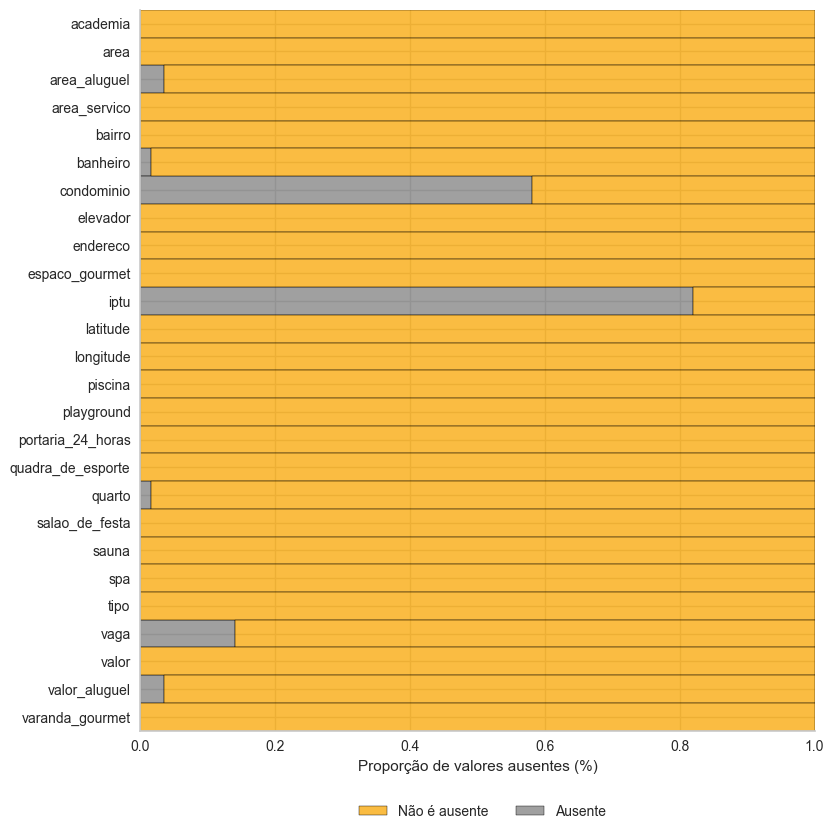

In [10]:
g_missing = sns.displot(
    data=train_df.isnull() \
        .melt(value_name="Valores ausentes") \
        .replace([False, True], ["Não é ausente", "Ausente"]) \
        .groupby(["variable", "Valores ausentes"]).size() \
        .reset_index(name="count") \
        .assign(
            proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
        ),
    y="variable",
    hue="Valores ausentes",
    weights="proportion",
    multiple="fill",
    height=8,
    aspect=1.1,
    palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
    )

sns.move_legend(obj=g_missing, loc="upper center",
                bbox_to_anchor=(.5, -.0001), ncol=2, title="")
g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

### Some functions

In [109]:
def display_scores(scores, confidence=0.95):

    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrão:", scores.std())

In [110]:
def plot_error(scores):
    ax, fig = plt.subplots(figsize=(20, 20))
    lineplot = sns.lineplot(y=scores, x=list(range(1, 11)))
    plt.title('Raiz do erro quadrático médio', fontdict={'fontsize': 18})
    plt.xlabel('CV', fontdict={'fontsize': 14})
    plt.ylabel('RMSE', fontdict={'fontsize': 14})
    lineplot.set_xticklabels(lineplot.get_xticklabels(), fontdict={'fontsize': 13})
    lineplot.set_yticklabels(lineplot.get_yticklabels(), fontdict={'fontsize': 13})
    plt.show()

In [111]:
def plot_predict(model):
    plt.figure(figsize=(20, 20))
    scatter = sns.scatterplot(y=np.exp(model.predict(test_df.drop('valor', axis=1))), x=np.exp(test_df.valor) - 1)
    plt.title('Predições VS Valores Reais', fontdict={'fontsize': 18})
    plt.xlabel('Valores Reais', fontdict={'fontsize': 13})
    plt.ylabel('Predições', fontdict={'fontsize': 13})
    plt.show()

In [117]:
gbr_native = ensemble.GradientBoostingRegressor()
lgbm_native = LGBMRegressor()
rf_native = ensemble.RandomForestRegressor()
xgboost_native = XGBRegressor()

## Modeling 

In [12]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [102]:
drop_cols_fit = ['endereco', 'bairro', 'iptu', 'condominio']

pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("new_feature", BedAreaBedToi()),
     ("ordinal_encoder", OrdEncoder()),
     ("onehot_encoder", OneEncoder()),
     ("log_transform", LogTransform()),
     ("scaling", Scale())
    ])
pipe_jp.fit(train_df.drop(columns=drop_cols_fit))

Pipeline(steps=[('imputer', Imputer()), ('new_feature', BedAreaBedToi()),
                ('ordinal_encoder', OrdEncoder()),
                ('onehot_encoder', OneEncoder()),
                ('log_transform', LogTransform()), ('scaling', Scale())])

In [105]:
train_df_novo = pipe_jp.transform(train_df.drop(columns=drop_cols_fit))
test_df_novo = pipe_jp.transform(test_df.drop(columns=drop_cols_fit))

In [17]:
# s = setup(train_df_novo, target='valor')
# best = compare_models()

## Optim

### LGBM

In [119]:
def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    max_depth = trial.suggest_int('max_depth', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, .01)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [120]:
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2024-09-10 19:23:09,687] A new study created in memory with name: no-name-34f1c535-9f59-47ce-8718-377b675d3778


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] [LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027471 seconds.
You can set `force_col_wise=true` to remove the overhead.
Auto-choosing row-wise multi-threading, the overhead of testing was 0.016206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 28
[LightGBM] [Info] Start training from score 13.051175
[LightGBM] [Info] Start training from score 

In [125]:
best_params_lgbm = {
    'num_leaves': 247,
    'max_depth': 299,
    'learning_rate': 0.009035568789398086,
    'n_estimators': 1798}

In [127]:
joblib.dump(study_lgbm, 'study_pkl/study_lgbm.pkl')

['study_pkl/study_lgbm.pkl']

### Random Forest

In [43]:
forest = ensemble.RandomForestRegressor(
    n_estimators=1500,
    random_state=42,
    max_depth=100,
    max_features="sqrt",
    n_jobs=1)

In [44]:
forest.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

RandomForestRegressor(max_depth=100, max_features='sqrt', n_estimators=1500,
                      n_jobs=1, random_state=42)

In [45]:
forest.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8660368903247242

In [46]:
test_df_clone = test_df.copy()

In [47]:
preds = forest.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds'] = preds

<Axes: xlabel='preds', ylabel='valor'>

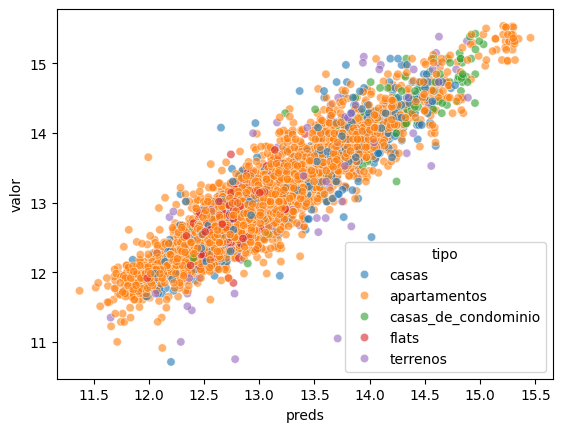

In [48]:
sns.scatterplot(data=test_df_clone, x='preds', y='valor', hue='tipo', alpha=.6)

In [115]:
def objective_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int(name='n_estimators', low=1, high=1000),
        max_depth=trial.suggest_int(name='max_depth', low=20, high=1000),
        max_features='sqrt'
        min_impurity_decrease=trial.suggest_float(name='min_impurity_decrease', low=1e-7, high=10, log=True),
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params,
        n_jobs=3
    )
    model.fit(X=train_df.drop('valor', axis=1), y=train_df.valor)

    cv_scores = np.exp(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df.drop("valor", axis=1),
        y=train_df.valor,
        scoring="neg_mean_squared_error",
        n_jobs=3,
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [15]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_rf, n_trials=100)

[I 2024-06-10 06:56:39,761] A new study created in memory with name: no-name-fd28fe78-8d67-4af6-8a0e-89c85209e279
[I 2024-06-10 06:58:09,411] Trial 0 finished with value: 1.2928082014110964 and parameters: {'n_estimators': 332, 'max_depth': 676, 'min_impurity_decrease': 1.335513326647804e-06}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 06:59:57,771] Trial 1 finished with value: 1.3212561835006036 and parameters: {'n_estimators': 637, 'max_depth': 499, 'min_impurity_decrease': 6.028001632581856e-05}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 07:00:32,404] Trial 2 finished with value: 1.7216743552488292 and parameters: {'n_estimators': 864, 'max_depth': 757, 'min_impurity_decrease': 0.12520837838688012}. Best is trial 0 with value: 1.2928082014110964.
[I 2024-06-10 07:00:39,930] Trial 3 finished with value: 1.3112921769300194 and parameters: {'n_estimators': 37, 'max_depth': 151, 'min_impurity_decrease': 3.185968995257272e-05}. Best is trial 0 with 

In [37]:
plot = optuna.visualization.plot_param_importances(study)
plot.update_layout(
    title="",
    xaxis_title="Importância dos Hiperparâmetros",
    yaxis_title="Hiperparâmetros"
)